# Naïve Bayes

This algorithm assigns a class $\hat{c}_k$ from all the possible classes in $\mathbf{C}$, to each $y_i$ in $\mathbf{Y}$ using the Bayes Theorem as follows:

$$
P\left(\mathbf{C}\,\middle|\,\{\mathbf{X}_j\}\right) = \frac{\mathcal{L}\left(\{\mathbf{X}_j\}\,\middle|\,\mathbf{C}\right) \times P\left(\mathbf{C}\right)}{P\left(\mathbf{X}_j\right)}
$$

where:

$P\left(\mathbf{C}\,\middle|\,\{\mathbf{X}_j\}\right)$ is the posterior probability distribution, that is, given the observed feature set $\{\mathbf{X}_j\}$.

$\mathcal{L}\left(\{\mathbf{X}_j\}\,\middle|\,\mathbf{C}\right)$ is the likelihood *function* (not distribution) which holds information on the probability of having observed the feature set $\{\mathbf{X}_j\}$ taking as ground truth the classes $\mathbf{C}$.

$P\left(\mathbf{C}\right)$ is the prior probability distribution of $\mathbf{C}$, that is, the probability of each class in the absence of any observation in the feature set.

$P\left(\mathbf{X}_j\right)$ this is the posterior probability distribution integrated over all classes. It is also called the evidence.

Thus, given a set of features $\{\mathbf{X}_j\}$ and our pejudices about the possible classes $\mathbf{C}$, this algorithm seeks the maximum of the posterior probability that assigns the class $\hat{c}_k$ to the set $\{\mathbf{X}_j\}$.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

sns.set(context="notebook", style="darkgrid", palette="muted", color_codes=True)

In [2]:
def data_split(dataset, ratio=0.9):
    """Splits the given dataset in the given ratio.
    
    Given a dataset and a ratio this function returns
    two datasets representing the first fraction of the
    dataset row-wise and the complementary subset.
    """
    N = dataset.shape[0]
    S = int(N*ratio)
    subset_1, subset_2 = dataset[:S], dataset[S:]
    return subset_1, subset_2

def remove_columns(dataset, in_strings, inplace=False):
    """Removes the given columns from the dataset
    
    Given a dataset and a set of columns, this function
    returns a dataset without those columns. If inplace
    is True, returns None and the given dataset will be
    modified.
    """
    to_remove = [column for column in dataset.columns for _str in in_strings if _str in column]
    return dataset.drop(columns=to_remove, inplace=inplace)

def normalize_metadata(dataset, inplace=False):
    if inplace:
        ds = dataset
    else:
        ds = dataset.copy()
    
    ds.index = pd.to_datetime(ds.index)
    ds.columns = map(lambda name: name.lower(), ds.columns)
    ds.index.name = ds.index.name.lower()
    return None if inplace else ds

In [3]:
X_raw = pd.read_csv("../data/processed/sp500-ml/features-raw.csv", index_col=0, parse_dates=True, header=[0, 1])
Y_raw = pd.read_csv("../data/processed/sp500-ml/target-raw.csv", index_col="Date", parse_dates=True)

Y_raw.replace({"Class": {0: -1}}, inplace=True)

X_raw.drop(labels=["S&P 500 sectors", "Stocks", "Economical", "CFDs", "Currencies"], level="Type", axis="columns", inplace=True)
X_raw.columns = X_raw.columns.droplevel("Type")

X_raw.fillna(method="ffill", inplace=True)
X_raw.dropna(how="any", axis="index", inplace=True)
Y_raw = Y_raw.reindex(index=X_raw.index)
Y_raw.dropna(how="any", axis="index", inplace=True)
X_raw = X_raw.reindex(index=Y_raw.index)

X = X_raw.copy()[X_raw.index <= "2018-01-01"]
Y = Y_raw.copy()[X_raw.index <= "2018-01-01"]["Class"]
sp500 = Y_raw.loc[X_raw.index <= "2018-01-01", "S&P 500 price"]

In [9]:
# implement data normalization
X_norm = X.apply(preprocessing.scale)
# implement data splitting
X_train, X_test = data_split(X_norm, ratio=0.8)
Y_train, Y_test = data_split(Y, ratio=0.8)
sp500_train, sp500_test = data_split(sp500, ratio=0.8)
# implement model training
cls = GaussianNB(priors=[0.5, 0.5])
cls.fit(X_train, Y_train)
# implement model testing
Y_pred = cls.predict(X_test)
# implement model evaluation
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
model_eval = pd.DataFrame(data=[accuracy, precision, recall], index="Accuracy Precision Recall".split(), columns=["Model Evaluation"])
model_eval

,Model Evaluation
Accuracy,0.761755
Precision,0.768421
Recall,0.820225


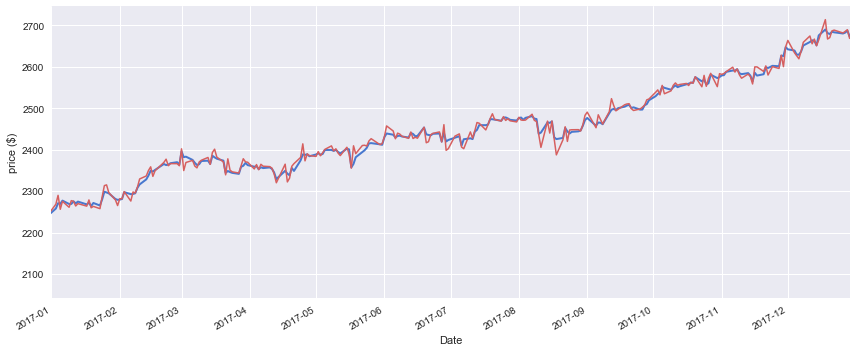

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sp500_test.plot(lw=2.0)

delta_y = abs(sp500_test.diff().shift())
delta_y.fillna(0.0, inplace=True)
y = sp500_test
price_pred = Y_pred*delta_y + y

ax.plot(X_test.index, price_pred, lw=1.5, color="r")
ax.set_xlim(pd.date_range("2017-01-01", X_test.index[-1]).date[[0,-1]])
ax.set_ylabel(r"price ($)")
fig.tight_layout()

,Model Evaluation
Accuracy,0.755814
Precision,0.759259
Recall,0.836735


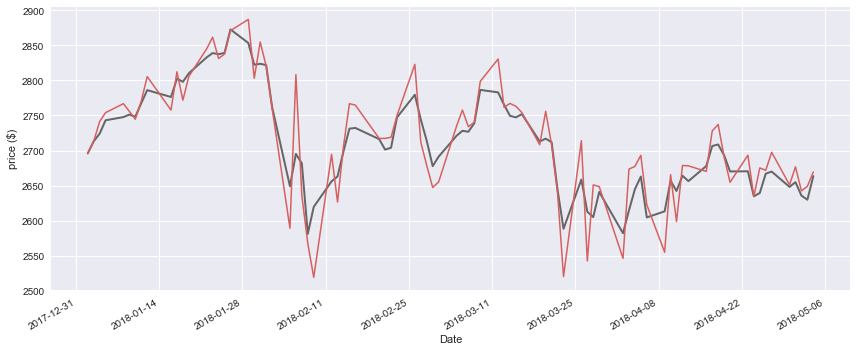

In [11]:
X_prediction = X_raw.copy()[X_raw.index >= "2018-01-01"]
Y_actual = Y_raw.copy()[X_raw.index >= "2018-01-01"]["Class"]
sp500_prediction = Y_raw.loc[X_raw.index >= "2018-01-01", "S&P 500 price"]

X_prediction = X_prediction.apply(preprocessing.scale)
Y_prediction = cls.predict(X_prediction)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sp500_prediction.plot(lw=2.0, color="0.4")

delta_y = abs(sp500_prediction.diff().shift())
delta_y.fillna(0.0, inplace=True)
y = sp500_prediction
price_pred = Y_prediction*delta_y + y

ax.plot(X_prediction.index, price_pred, lw=1.5, color="r")
ax.set_ylabel(r"price ($)")
fig.tight_layout()

accuracy = accuracy_score(Y_actual, Y_prediction)
precision = precision_score(Y_actual, Y_prediction)
recall = recall_score(Y_actual, Y_prediction)
# print classification_report(Y_actual, Y_prediction)
model_eval = pd.DataFrame(data=[accuracy, precision, recall], index="Accuracy Precision Recall".split(), columns=["Model Evaluation"])
model_eval

In [12]:
pd.DataFrame(
    index=sp500_prediction.index,
    columns=["Actual", "Prediction"],
    data=np.column_stack((Y_actual, Y_prediction))
).tail(n=10)

,Actual,Prediction
Date,,
2018-04-23,1.0,1.0
2018-04-24,-1.0,-1.0
2018-04-25,1.0,1.0
2018-04-26,1.0,1.0
2018-04-27,1.0,1.0
2018-04-30,-1.0,1.0
2018-05-01,1.0,1.0
2018-05-02,-1.0,1.0
2018-05-03,-1.0,1.0
